In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [7]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        # FS 파라미터 정의 (학습 가능한 파라미터로 설정)
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))

    def forward(self, x):
        v = x

        # FS 스파이크 신경망을 위한 임시 출력 초기화
        temp_out = torch.zeros_like(v)

        # FS 스파이크 신경망 구현
        for t in range(len(self.T)):
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]  # 모든 타임스텝에서 동일한 학습 가능한 h 파라미터 사용

        return temp_out

# Sigmoid

K=4

Epoch 1/20000, Loss: 1.4269307851791382
Epoch 1001/20000, Loss: 0.06747238337993622
Epoch 2001/20000, Loss: 0.020893948152661324
Epoch 3001/20000, Loss: 0.010185949504375458
Epoch 4001/20000, Loss: 0.005191048141568899
Epoch 5001/20000, Loss: 0.0023168257903307676
Epoch 6001/20000, Loss: 0.0012851404026150703
Epoch 7001/20000, Loss: 0.0011732575949281454
Epoch 8001/20000, Loss: 0.0011607910273596644
Epoch 9001/20000, Loss: 0.001158040715381503
Epoch 10001/20000, Loss: 0.0011570467613637447
Epoch 11001/20000, Loss: 0.001152222859673202
Epoch 12001/20000, Loss: 0.0010985244298353791
Epoch 13001/20000, Loss: 0.0007252104696817696
Epoch 14001/20000, Loss: 0.000589983887039125
Epoch 15001/20000, Loss: 0.0006498261936940253
Epoch 16001/20000, Loss: 0.0006432508234865963
Epoch 17001/20000, Loss: 0.0006431897054426372
Epoch 18001/20000, Loss: 0.0006432023365050554
Epoch 19001/20000, Loss: 0.0006431892979890108
Loss values: [1.4269307851791382, 0.5603125095367432, 0.24095341563224792, 0.1274889

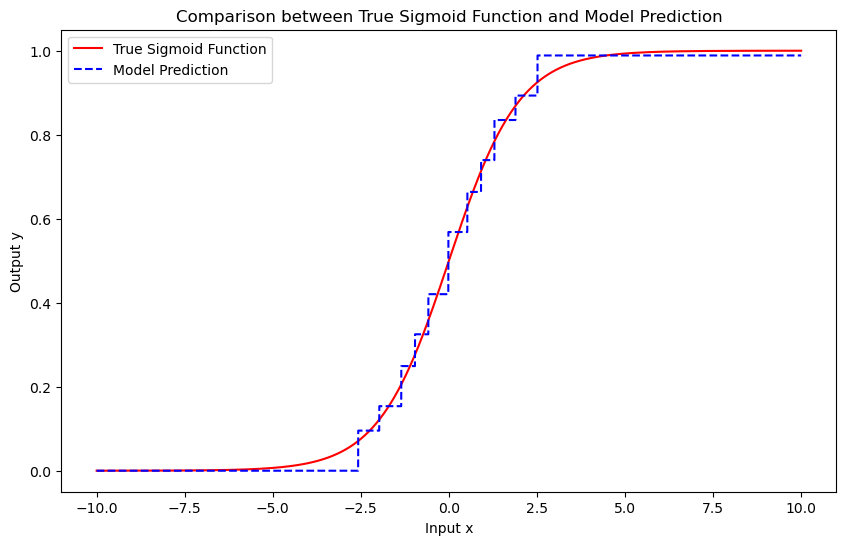

In [8]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Adjusting training data distribution
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
x_train = torch.cat((
    torch.linspace(-10, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 10, steps=20000),
))
y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Sigmoid Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Sigmoid Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

Epoch 1/20000, Loss: 3.6140034198760986
Epoch 1001/20000, Loss: 0.14554348587989807
Epoch 2001/20000, Loss: 0.06262367218732834
Epoch 3001/20000, Loss: 0.024754848331212997
Epoch 4001/20000, Loss: 0.013563642278313637
Epoch 5001/20000, Loss: 0.0061854710802435875
Epoch 6001/20000, Loss: 0.0030775286722928286
Epoch 7001/20000, Loss: 0.002087725093588233
Epoch 8001/20000, Loss: 0.0016451828414574265
Epoch 9001/20000, Loss: 0.0009684886899776757
Epoch 10001/20000, Loss: 0.0007240423001348972
Epoch 11001/20000, Loss: 0.0006209867424331605
Epoch 12001/20000, Loss: 0.0005942505085840821
Epoch 13001/20000, Loss: 0.000565153721254319
Epoch 14001/20000, Loss: 0.0005317083559930325
Epoch 15001/20000, Loss: 0.0005192557582631707
Epoch 16001/20000, Loss: 0.0005035774083808064
Epoch 17001/20000, Loss: 0.0005049017490819097
Epoch 18001/20000, Loss: 0.0005182850873097777
Epoch 19001/20000, Loss: 0.0005288058309815824
Loss values: [3.6140034198760986, 1.3431081771850586, 0.6325287222862244, 0.32862344

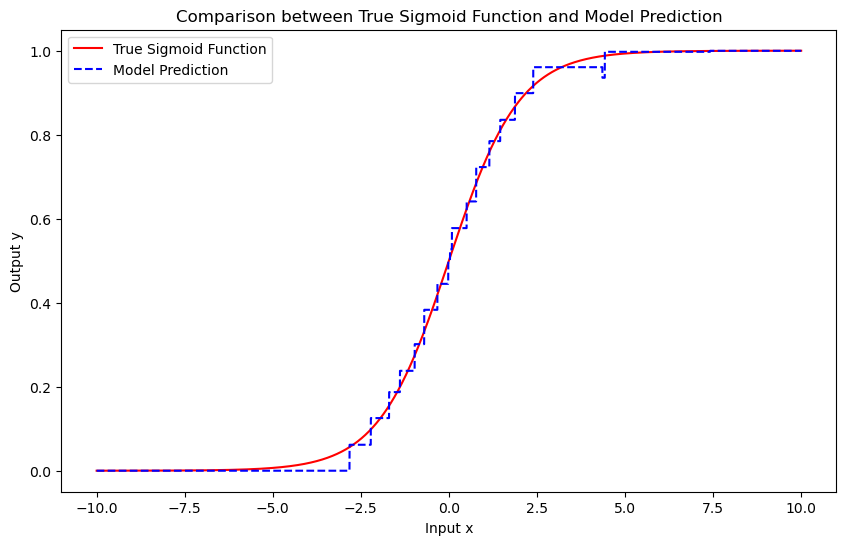

In [9]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Adjusting training data distribution
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
x_train = torch.cat((
    torch.linspace(-10, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 10, steps=20000),
))
y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Sigmoid Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Sigmoid Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=12

Epoch 1/20000, Loss: 18.53392219543457
Epoch 1001/20000, Loss: 0.973755419254303
Epoch 2001/20000, Loss: 0.4089781939983368
Epoch 3001/20000, Loss: 0.2578694820404053
Epoch 4001/20000, Loss: 0.16098149120807648
Epoch 5001/20000, Loss: 0.0901140496134758
Epoch 6001/20000, Loss: 0.040708284825086594
Epoch 7001/20000, Loss: 0.014817859046161175
Epoch 8001/20000, Loss: 0.005203333217650652
Epoch 9001/20000, Loss: 0.004407596308737993
Epoch 10001/20000, Loss: 0.0034715747460722923
Epoch 11001/20000, Loss: 0.001568751409649849
Epoch 12001/20000, Loss: 0.0011038297088816762
Epoch 13001/20000, Loss: 0.0008478042436763644
Epoch 14001/20000, Loss: 0.0007999104564078152
Epoch 15001/20000, Loss: 0.0006018372951075435
Epoch 16001/20000, Loss: 0.0004179157258477062
Epoch 17001/20000, Loss: 0.0003225891850888729
Epoch 18001/20000, Loss: 0.0003144619695376605
Epoch 19001/20000, Loss: 0.00028563966043293476
Loss values: [18.53392219543457, 8.928192138671875, 4.510998725891113, 2.5554051399230957, 1.513

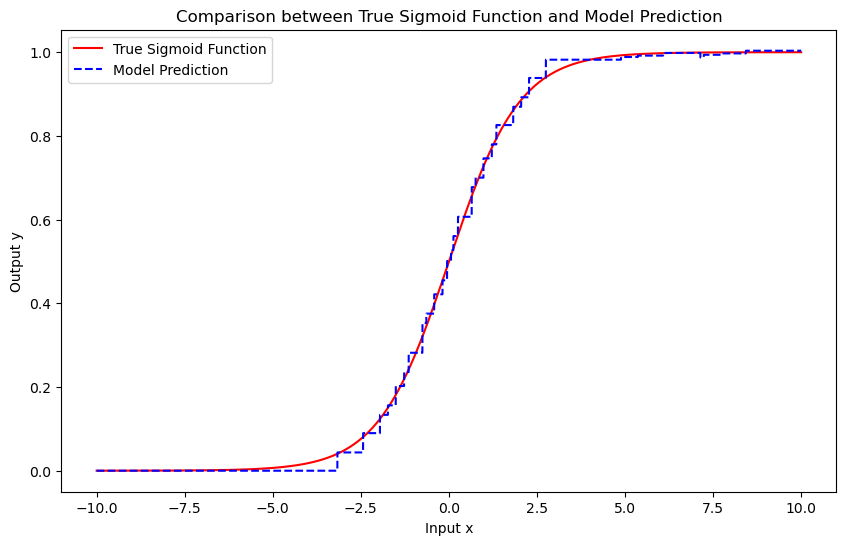

In [10]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Adjusting training data distribution
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
x_train = torch.cat((
    torch.linspace(-10, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 10, steps=20000),
))
y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Sigmoid Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Sigmoid Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 4.724729537963867
Epoch 1001/20000, Loss: 0.07074598968029022
Epoch 2001/20000, Loss: 0.03385980799794197
Epoch 3001/20000, Loss: 0.01511639729142189
Epoch 4001/20000, Loss: 0.007149231154471636
Epoch 5001/20000, Loss: 0.0034112255088984966
Epoch 6001/20000, Loss: 0.0023261893074959517
Epoch 7001/20000, Loss: 0.0016623894916847348
Epoch 8001/20000, Loss: 0.0011172262020409107
Epoch 9001/20000, Loss: 0.0009407703182660043
Epoch 10001/20000, Loss: 0.0006657801568508148
Epoch 11001/20000, Loss: 0.0004449721600394696
Epoch 12001/20000, Loss: 0.0003798880788963288
Epoch 13001/20000, Loss: 0.0002973578521050513
Epoch 14001/20000, Loss: 0.0002785666147246957
Epoch 15001/20000, Loss: 0.0002300231863046065
Epoch 16001/20000, Loss: 0.0001915282482514158
Epoch 17001/20000, Loss: 0.00017782575741875917
Epoch 18001/20000, Loss: 0.00016876746667549014
Epoch 19001/20000, Loss: 0.0001728619245113805
Loss values: [4.724729537963867, 1.0384068489074707, 0.3134765625, 0.1608243584632

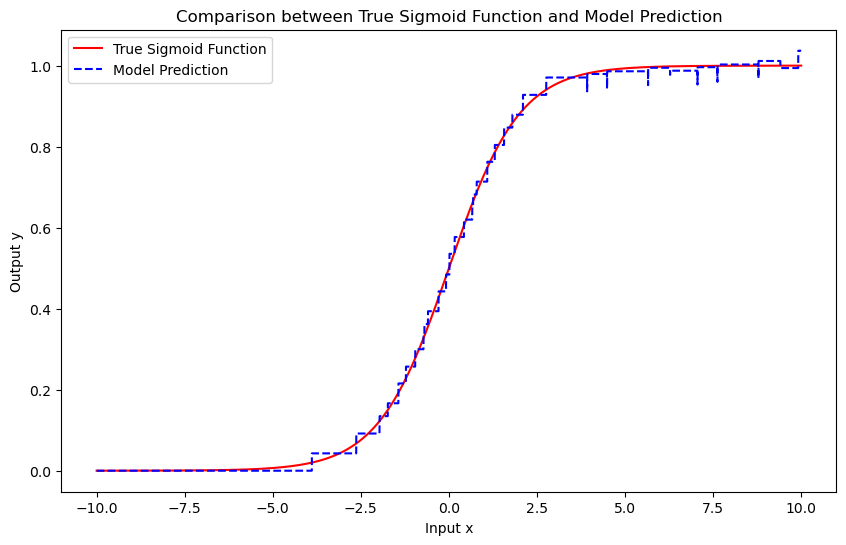

In [11]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Adjusting training data distribution
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
x_train = torch.cat((
    torch.linspace(-10, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 10, steps=20000),
))
y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Sigmoid Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Sigmoid Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=20

Epoch 1/20000, Loss: 13.430577278137207
Epoch 1001/20000, Loss: 0.5977351069450378
Epoch 2001/20000, Loss: 0.23361867666244507
Epoch 3001/20000, Loss: 0.10980580002069473
Epoch 4001/20000, Loss: 0.060315340757369995
Epoch 5001/20000, Loss: 0.02932877652347088
Epoch 6001/20000, Loss: 0.011300906538963318
Epoch 7001/20000, Loss: 0.004720729775726795
Epoch 8001/20000, Loss: 0.002977335127070546
Epoch 9001/20000, Loss: 0.001565122278407216
Epoch 10001/20000, Loss: 0.0012828260660171509
Epoch 11001/20000, Loss: 0.0011476490180939436
Epoch 12001/20000, Loss: 0.0011151672806590796
Epoch 13001/20000, Loss: 0.0006235875189304352
Epoch 14001/20000, Loss: 0.0005351726431399584
Epoch 15001/20000, Loss: 0.0003719836531672627
Epoch 16001/20000, Loss: 0.00028605948318727314
Epoch 17001/20000, Loss: 0.0003045196062885225
Epoch 18001/20000, Loss: 0.0002775328466668725
Epoch 19001/20000, Loss: 0.0002923093270510435
Loss values: [13.430577278137207, 5.006000518798828, 2.341022491455078, 1.227293848991394

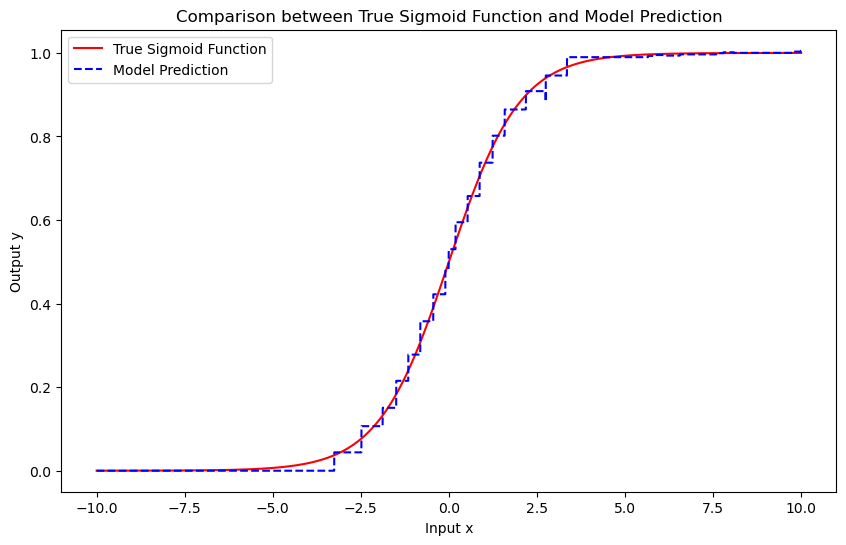

In [12]:
# Instantiate model and initial setup
num_params = 20  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Adjusting training data distribution
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
x_train = torch.cat((
    torch.linspace(-10, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 10, steps=20000),
))
y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Sigmoid Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Sigmoid Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=24

Epoch 1/20000, Loss: 9.817384719848633
Epoch 1001/20000, Loss: 0.12291886657476425
Epoch 2001/20000, Loss: 0.07098762691020966
Epoch 3001/20000, Loss: 0.03619196265935898
Epoch 4001/20000, Loss: 0.013265356421470642
Epoch 5001/20000, Loss: 0.00514775887131691
Epoch 6001/20000, Loss: 0.00332305277697742
Epoch 7001/20000, Loss: 0.002634563948959112
Epoch 8001/20000, Loss: 0.0026658971328288317
Epoch 9001/20000, Loss: 0.0013053060974925756
Epoch 10001/20000, Loss: 0.0010284717427566648
Epoch 11001/20000, Loss: 0.0007817997829988599
Epoch 12001/20000, Loss: 0.0006696040509268641
Epoch 13001/20000, Loss: 0.0004410141264088452
Epoch 14001/20000, Loss: 0.0004702468868345022
Epoch 15001/20000, Loss: 0.00030541155138053
Epoch 16001/20000, Loss: 0.00034113784204237163
Epoch 17001/20000, Loss: 0.00022105379321146756
Epoch 18001/20000, Loss: 0.00024205486988648772
Epoch 19001/20000, Loss: 0.00026452913880348206
Loss values: [9.817384719848633, 2.6457173824310303, 0.9657802581787109, 0.349871516227

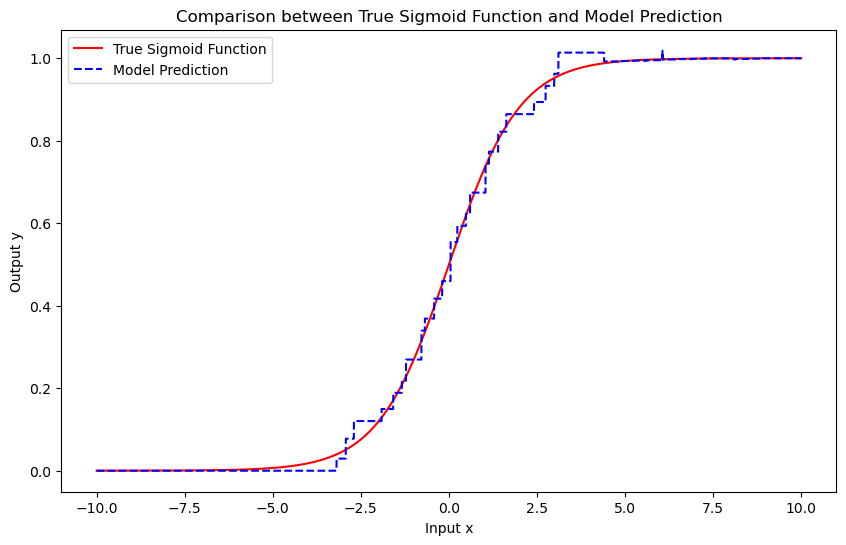

In [13]:
# Instantiate model and initial setup
num_params = 24  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Adjusting training data distribution
#x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
x_train = torch.cat((
    torch.linspace(-10, -2, steps=20000),
    torch.linspace(-2, 2, steps=60000),
    torch.linspace(2, 10, steps=20000),
))
y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Sigmoid Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Sigmoid Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()